# Relative Memorization- standard candles

I eval all checkpoints of the Hubble 1B param 100B toks model on the YAGO infill data as well as the MRPC and PAWS tasks from copyright. The goal is to plot relative memorization of each type of personal information that YAGO includes. MPRC and PAWS will be additional lines on the plot.

In [1]:
import json
import pandas as pd
import numpy as np
import glob
import os
from math import exp
import re
from git import Repo
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from huggingface_hub import list_repo_refs

In [44]:
def get_newest_file(wildcard):
    return sorted(glob.glob(wildcard))[-1] # SNEAKY: glob returns all matches, which may be mutiple files. if u have mutiple runs of same model and checkpoint but diff timestamp then youll get duplicate data (same runs but run at diff times). thats why u have to index w -1 to get latest file 

In [62]:
def get_all_accs(filepath, field_type, num_dups):
    all_accs = []
    fp = get_newest_file(filepath) 
    with open(fp, "rt") as f:
        for line in f:
            if f'\"duplicates\": {num_dups}' not in line:
                continue
            obj = json.loads(line)
            meta = json.loads(obj['doc']['meta'])
            if obj['doc']['field_type'] == field_type:
                all_accs.append(obj['acc'])
    
    return all_accs

In [45]:
def parse_checkpoints(model):
    """
    Extract checkpoint numbers (as ints) from a list of GitRefInfo objects returned by Huggingface API.
    Only keeps refs whose name starts with 'step'.
    """
    refs = list_repo_refs(f"allegrolab/{model}").tags
    checkpoints = []
    for ref in refs:
        if ref.name.startswith("step"):
            try:
                step_num = int(ref.name.replace("step", ""))
                # if step_num >= 2000: # dont want earlier checkpoints plotted
                checkpoints.append(step_num)
            except ValueError:
                # in case a tag isn't just step<number>, skip it
                continue
    return sorted(checkpoints)

In [69]:
models = [
    # 'hubble-1b-100b_toks-standard-hf',
    'hubble-1b-100b_toks-perturbed-hf',
    # 'hubble-1b-100b_toks-injectrange_0_25-hf',
    # 'hubble-1b-100b_toks-injectrange_25_50-hf',
    # 'hubble-1b-100b_toks-injectrange_50_75-hf',
    # 'hubble-1b-100b_toks-injectrange_75_100-hf',
    # 'hubble-1b-100b_toks-injectrange_0_50-hf',
    # 'hubble-1b-100b_toks-injectrange_50_100-hf',
]

tasks_privacy = [
    # "yago_hubble_full_prefix_full_suffix",
    # "yago_hubble_full_prefix_no_suffix",
    "yago_hubble_intro_prefix_no_suffix",
    # "yago_hubble_name_only_prefix_no_suffix",
    # "yago_hubble_full_prefix_gen",
    # "yago_hubble_intro_prefix_gen",
    # "yago_hubble_name_only_prefix_gen",
    # "ecthr_hubble_full_prefix_gen"
    
]

metrics_privacy = [
    # 'acc',
    # 'acc',
    'acc',
    # 'acc',
    # 'squad_recall',
    # 'squad_recall',
    # 'squad_recall',
    # 'squad_recall',
]

tasks_copyright = [
    "paws_hubble",
    "mrpc_hubble",
]

metrics_copyright = [
    'acc',
    'acc',
]

field_types = [
    'nationality',
    'occupation',
    'birthplace',
    'birthdate',
    'uuid',
    'email',
    'alumni_of',
]

num_dups = [16,
            64,
            256,
           ]

## Creating the DFs
let's create the dict of dataframes to reuse ameya's plotting code

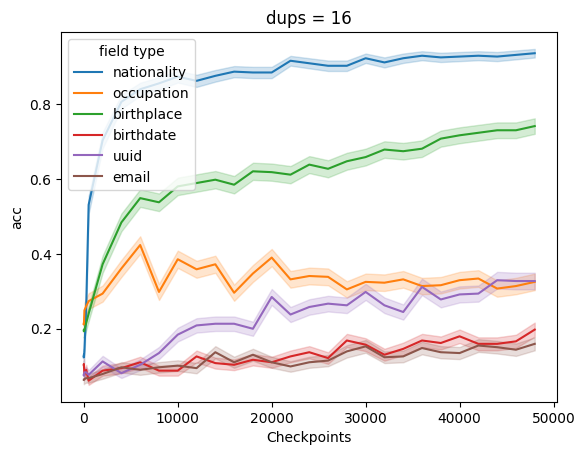

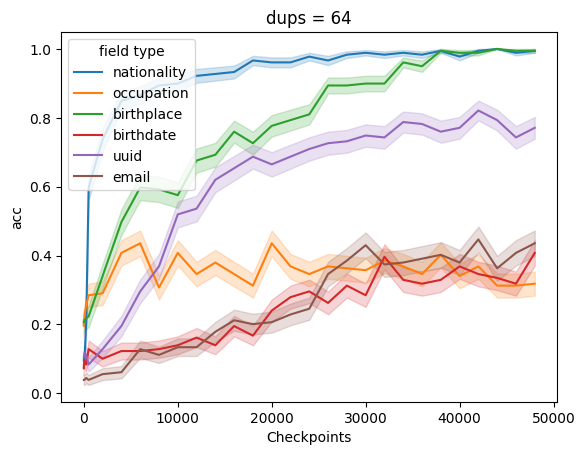

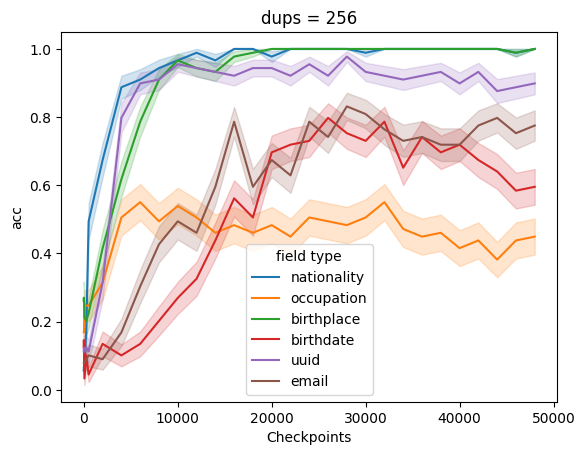

In [70]:
dfs = {}
model = 'hubble-1b-100b_toks-perturbed-hf'
task = "yago_hubble_intro_prefix_no_suffix"
metric = 'acc'

for dups in num_dups: 
    all_model_names = []
    all_checkpoints = []
    all_metrics = []
    all_field_types = []
        
    metrics_one_file = []
    checkpoints = parse_checkpoints(model)
    
    for checkpoint in checkpoints:
        for field_type in field_types:
            
            filepath = f'/project2/robinjia_875/nityakas/outputs/relative-memorization/yago-infill/sample_{model}_step{checkpoint}/allegrolab__{model}/samples_{task}_*.jsonl'
            
            metrics_one_file = get_all_accs(filepath, field_type, dups) 
            all_metrics.extend(metrics_one_file) # using extend() bc u want to extend the list, not add the list as a new entry and create a list of lists sitch (which is what append would do)
        
            
            all_checkpoints.extend([checkpoint]*len(metrics_one_file))
            all_field_types.extend([field_type]*len(metrics_one_file))
            
            model_name = model.removeprefix("hubble-1b-100b_toks-").removesuffix("-hf")
            all_model_names.extend([model_name]*len(metrics_one_file))

            
    df = pd.DataFrame({
        "Model" : all_model_names, 
        "Checkpoints" : all_checkpoints,
        'field type' : all_field_types,
        metric: all_metrics 
    })

    dfs[task] = df

    plt.figure()
    sns.lineplot(data = dfs['yago_hubble_intro_prefix_no_suffix'],
             x = 'Checkpoints',
             y = 'acc',
             hue = 'field type',
             errorbar = 'se',
            )
    plt.title(f'dups = {dups}')

## Missing Checkpoints
*My ssh connection broke midway- some checkpoints evals might not have finished before then. let's see which ones:*

In [7]:
def get_hf_checkpoints(model):
    refs = list_repo_refs(f"allegrolab/{model}").tags
    return sorted(
        int(ref.name.replace("step", ""))
        for ref in refs
        if ref.name.startswith("step")
    )
    
def get_local_checkpoints(model, base="/project2/robinjia_875/nityakas/outputs/relative-memorization/yago-infill"):
    pattern = f"{base}/sample_{model}_step*"
    dirs = glob.glob(pattern)
    return sorted(
        int(os.path.basename(d).split("step")[-1])
        for d in dirs
    )

def identify_missing_checkpoints(model):
    hf = set(get_hf_checkpoints(model))
    local = set(get_local_checkpoints(model))
    missing = sorted(hf - local)
    return missing

models = [
    # 'hubble-1b-100b_toks-standard-hf',
    'hubble-1b-100b_toks-perturbed-hf',
    'hubble-8b-100b_toks-perturbed-hf',
    # 'hubble-1b-100b_toks-standard-hf',
]
for model in models:
    print(f'{model} is missing:\n {identify_missing_checkpoints(model)}\n****************************************\n')

hubble-1b-100b_toks-perturbed-hf is missing:
 []
****************************************

hubble-8b-100b_toks-perturbed-hf is missing:
 [1, 4, 16, 64, 256, 512, 2000, 4000, 6000, 8000, 10000, 12000, 14000, 16000, 18000, 20000, 22000, 24000, 26000, 28000, 30000, 32000, 34000, 36000, 38000, 40000, 42000, 44000, 46000, 48000]
****************************************



ok no worries, all submitted jobs went thru! 8b we can deal with later